In [1]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter

import soundfile as sf

import phast
import abt

from matlab import MatlabData
from utils import bin_over_y
from plotting import plot_pulse_train_stats

In [2]:
MIN_FREQ = 350
MAX_FREQ = 5000

FS = 17400
NAME = "tone_1kHz"
N_MELS = 80
N_FFT = 2048
N_HOP = N_FFT // 32
CS = True



MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 
MAT = MatlabData.read()

IDET = MAT.I_det[:, 4::8] if not CS else MAT.I_det
scaling_factor = 0.9

scaling_factor_no_m_t = 2.6

freq_f = scipy.interpolate.interp1d(
    np.r_[0, np.argmin(MAT.I_det[:,::8], axis=0), 3200], 
    np.r_[0, abt.utils.virtual_channel_frequencies(16, MAX_FREQ - 500), MAX_FREQ], 
    fill_value='extrapolate'
)

fidx = np.arange(0, 3200)
int_freq = freq_f(fidx)

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = 'c',
    # M=MAT.M * 1e6 / scaling_factor,
    # T=MAT.T * 1e6 / scaling_factor,
    Fs = FS,
    stim_db = 65.0,
    ramp_duration=0.1
)
pulse_train *= scaling_factor_no_m_t

audio_signal = audio_signal[0]
duration = len(audio_signal) * (1 / FS)

cycle = 2 * 15
cycle_time = cycle * 18e-6
n_channels = pulse_train.shape[0]

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)
print(ref_db)
print(S.shape)
print(duration)


27.922329
(80, 544)
2.0


''

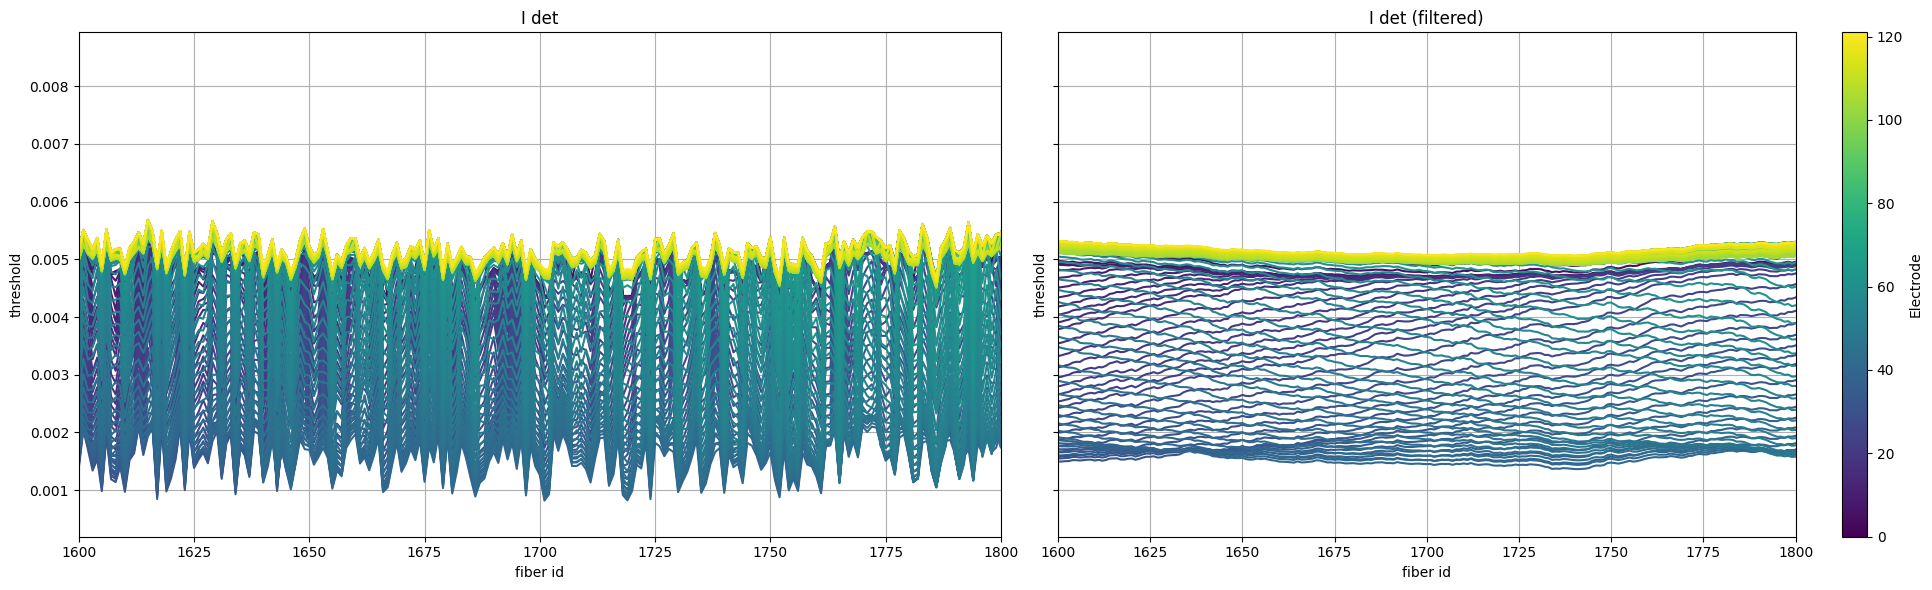

In [4]:
class Colorizer:
    def __init__(self, vmin=0, vmax=1, cmap_name = 'viridis'):
        cmap = plt.get_cmap(cmap_name)
        import matplotlib.colors as mcolors
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        self.scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
    def __call__(self, value):
        return self.scalar_map.to_rgba(value)

def filt(x):
    return scipy.signal.savgol_filter(x, 64, 2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True, sharex=True)
c = Colorizer(vmax=121)
for e in range(0, 121, 1):
    ax1.plot(MAT.I_det[:, e], color=c(e))
# fig.colorbar(c.scalar_map, ax=ax1)    
ax1.set_title("I det")

c = Colorizer(vmax=121)
for e in range(0, 121, 1):
    ax2.plot(filt(MAT.I_det[:, e]), color=c(e))
fig.colorbar(c.scalar_map, ax=ax2, label="Electrode")
ax2.set_title("I det (filtered)")
ax2.set_xlim(1600, 1800)

for ax in ax1, ax2:    
    ax.set_xlabel("fiber id")
    ax.grid()
    ax.set_ylabel("threshold")

plt.tight_layout()
;

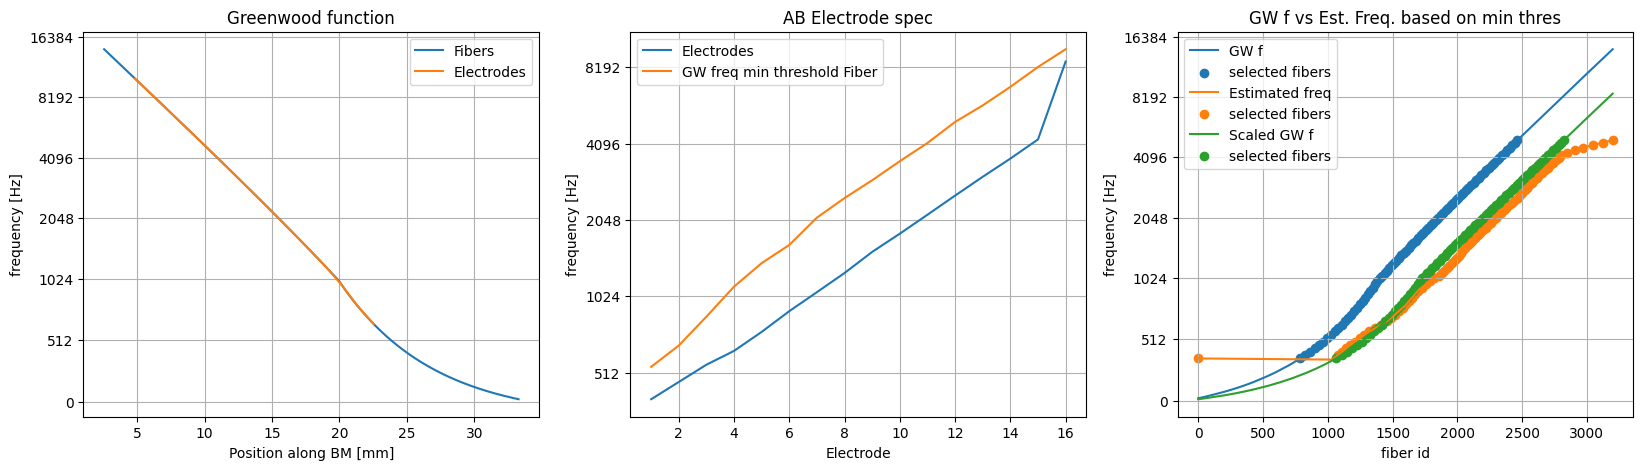

In [185]:
freq_f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(MAT.mat['Df120']['Ln'][0], MAT.mat['Df120']['Fn'][0] * 1e3, label="Fibers")
ax1.plot(MAT.mat['Df120']['Le'][0], MAT.mat['Df120']['Fe'][0] * 1e3, label="Electrodes")
ax1.set_xlabel("Position along BM [mm]")
abt.utils.frequency_ax(ax1)
ax1.legend()
ax1.grid()
ax1.set_title("Greenwood function")

electrodes = np.arange(1, 17)
gwf_min_thresh = MAT.greenwood_f[np.argmin(MAT.I_det[:,::8], axis=0)]

ax2.plot(electrodes, abt.utils.virtual_channel_frequencies(16), label="Electrodes")
ax2.plot(electrodes, gwf_min_thresh, label="GW freq min threshold Fiber")

ax2.legend()
ax2.grid()
ax2.set_title("AB Electrode spec")
ax2.set_xlabel("Electrode")
abt.utils.frequency_ax(ax2)


# # Remapping selected fibers
min_thresh_fiber_idx = np.argmin(MAT.I_det[:,:], axis=0)

freq_f = scipy.interpolate.interp1d(
    np.r_[0, np.argmin(MAT.I_det[:,::8], axis=0), 3200], 
    np.r_[MIN_FREQ, abt.utils.virtual_channel_frequencies(16, MAX_FREQ - 500), MAX_FREQ], 
    fill_value='extrapolate'
)

fidx = np.arange(0, 3200)
int_freq = freq_f(fidx)

# ax2.plot(fidx, int_freq)

gwf = MAT.greenwood_f.copy()
gwf_scaled = gwf * .6

selected_fibers_gw = np.array([abt.utils.find_nearest_idx(gwf, val) for val in MEL_SCALE])
selected_fibers_gw_scaled = np.array([abt.utils.find_nearest_idx(gwf_scaled, val) for val in MEL_SCALE])
selected_fibers_est = np.array([abt.utils.find_nearest_idx(int_freq, val) for val in MEL_SCALE])

p = ax3.plot(fidx, gwf, label="GW f")
ax3.scatter(selected_fibers_gw, gwf[selected_fibers_gw], color=p[0].get_color(), label='selected fibers')
p = ax3.plot(fidx, freq_f(fidx), label="Estimated freq")
ax3.scatter(selected_fibers_est, int_freq[selected_fibers_est], color=p[0].get_color(), label='selected fibers')

p = ax3.plot(fidx, gwf_scaled, label="Scaled GW f")
ax3.scatter(selected_fibers_gw_scaled, gwf_scaled[selected_fibers_gw_scaled], color=p[0].get_color(), label='selected fibers')


ax3.legend()
ax3.set_xlabel("fiber id")
abt.utils.frequency_ax(ax3)
ax3.grid()
ax3.set_title("GW f vs Est. Freq. based on min thres");

# # Using estimated fibers
selected_fibers = selected_fibers_est
selected_fibers_freq = int_freq[selected_fibers]

# # Using scaled Gw function
# selected_fibers = selected_fibers_gw_scaled
# selected_fibers_freq =  gwf_scaled[selected_fibers]

# # Using original Gw function
# # selected_fibers = selected_fibers_gw
# # selected_fibers_freq =  gwf[selected_fibers]

assert np.unique(selected_fibers).size == selected_fibers.size


(300.0, 6000.0)

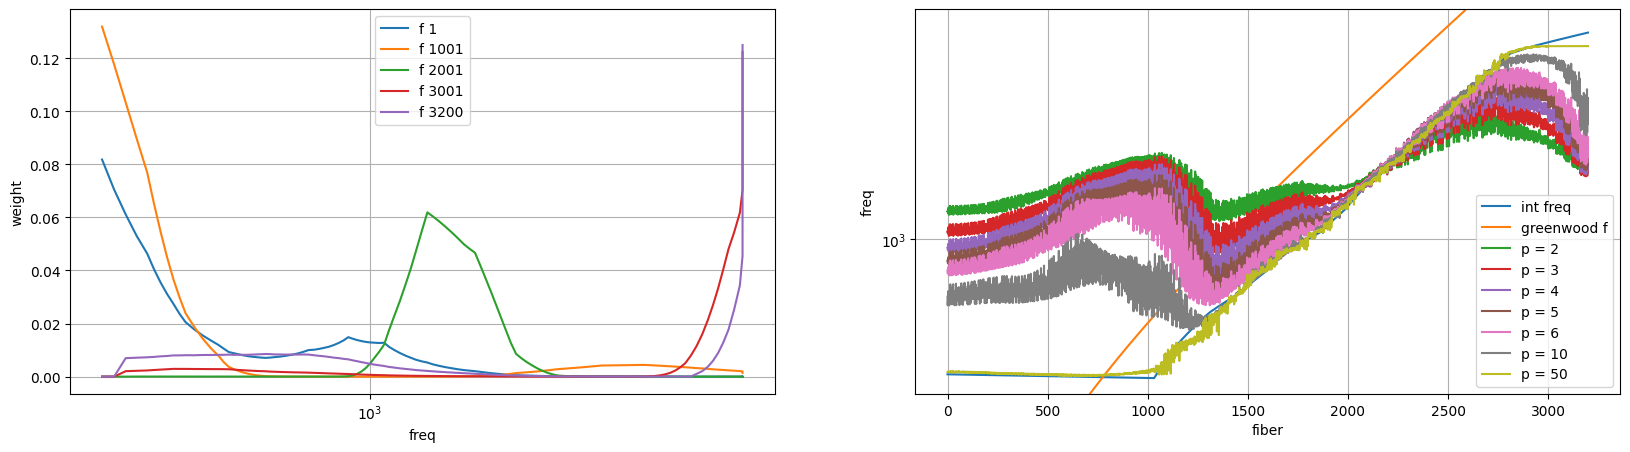

In [197]:
channel_freq = abt.utils.virtual_channel_frequencies(121, MAX_FREQ - 500)

power = 10
w1 = (-IDET / IDET.sum(axis=1).reshape(-1, 1)) + (2 / n_channels)
w = np.power(w1, power) / np.power(w1, power).sum(axis=1).reshape(-1, 1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

for fid in (0, 1000, 2000, 3000, 3199):
    # ax1.plot(channel_freq, IDET[fid], label=f"threshold {fid}")
    ax1.plot(channel_freq, w[fid], label=f"f {fid+1}")
ax1.grid()
ax
ax1.set_xscale("symlog")
ax1.set_xlabel("freq")
ax1.set_ylabel("weight")
ax1.legend()

ax2.plot(int_freq, label="int freq")
ax2.plot(MAT.greenwood_f, label="greenwood f")

for power in (2, 3, 4, 5, 6, 10, 50):
    w2 = np.power(w1, power) / np.power(w1, power).sum(axis=1).reshape(-1, 1)
    estimated_freq = w2 @ channel_freq
    ax2.plot(estimated_freq, label=f"p = {power}")
ax2.legend()
ax2.grid()
ax2.set_yscale("symlog")
ax2.set_ylabel("freq")
ax2.set_xlabel("fiber")
ax2.set_ylim(300, MAX_FREQ + 1000)